Left "Cabin" out of the ensembles, mainly because I couldn't get a significant effect in a first run of random forests modeling (in R). There may be some value to it if we could figure out a way to convert cabin to distance from main deck.

Bootstrapped logistic regression and random forests had very similar results. They both tend to have higher omission error than comission error. But overall accuracy is ~0.7-0.8 for both, which I would call "good". I think Random Forests might be a little better at handling interactions, which I left out completely from my logistic regression. We might consider ensembling predictions from both models.

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier

In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/Data/Titanic/train.csv")

In [ ]:
K : int = 9999

In [ ]:
def shuffle(df : pd.DataFrame, balance_classes : bool = False, 
                      response : str ="Survived", frac : float = 1.0):
  """ randomly shuffle an input pandas dataframe object, optionally 
  enforcing balanced classes for a given response variable if asked """
  categories : np.array = np.unique(df[response])
  if balance_classes:
    class_counts : list[int] = [ 
      np.sum(df[response] == category) 
      for category in categories ]
    min_count = np.min(class_counts)
    df = pd.concat([ 
        df[ df[response] == c ].sample(n=min_count) 
        for c in categories ])
  else:
    df = df.sample(n=len(df))
  # wrap a pandas call to optionally split our dataframe
  # into testing / training combinations if a frac= argument
  # was applied
  if frac is not 1.0:
    train_set = df.copy().sample(frac=frac)
    test_set = df.copy().drop(train_set.index)
    return {'training': train_set, 'testing': test_set}
  else:
    return {'training': df}

def mean_center(df : pd.DataFrame):
  """ mean-variance center continuous variables in a dataframe as a pre-cursor
  to least-squares regression. This is important if you want to analyze effects
  sizes from the fitted regression parameters."""
  r = df.copy()
  return { 
    'mean': r.mean(),
    'sd' : r.std(),
    'scaled' : r.\
      subtract(r.mean()).\
      divide(r.std()) }

def string_to_ordinal(v : str):
  """ convert the individual characters in a string to 
  ordinal integer values as an alternative to working
  with categorical string values as predictors"""
  return np.sum([ ord(c) for c in str(v) ])

def scale(df : pd.DataFrame, scale : dict):
  """ apply a z-transformation (centering) to some dataframe"""
  return ( df - scale['mean'] ) / scale['sd']

def unscale(df : pd.DataFrame, scale : dict):
  """ back-transform a centered data.frame to its original values """
  pass

def get_interactions(df, variables, categoricals):
  pass

def get_weights(results_bs):
  pass

def mse(predicted : np.array, observed : np.array):
  return (1/len(predicted)) * np.sum((observed - predicted)**2) 

def accuracy(observed : np.array, predicted : np.array):
  # correct (total) / total
  return np.sum(observed == predicted) / len(observed)

def omission(observed : np.array, predicted : np.array):
  """ type one error estimator from observed vs. predicted values """
  # incorrect (zeros) / total (zeros)
  zeros : np.array = (observed == 0)
  return np.sum( observed[zeros] != predicted[zeros] ) / np.sum(zeros)

def commission(observed : np.array, predicted : np.array):
  """ type two error estimator from observed vs. predicted values """
  # incorrect (ones) / total (ones)
  ones : np.array = (observed == 1)
  return np.sum( observed[ones] != predicted[ones] ) / np.sum(ones)

def encode_design_matrix(df : pd.DataFrame, variables : list = [], 
  dummy_variables : list = [], normalize : bool = True):
  """ accepts an input pandas dataframe and optionally normalizes columns and 
  creates dummy variables for categoricals as a pre-cursor to fitting a model
  in scikit"""
  if normalize:
    normalized = mean_center(df[variables])
  else:
    normalized = df[variables]
  if len(dummy_variables) > 0:
    if normalize:
      x = normalized['scaled'].join(df[dummy_variables])
    else:
      x = normalized.join(df[dummy_variables])
    var_names = list(
      pd.get_dummies(x[variables + dummy_variables]).columns)
    x = pd.get_dummies(x[variables + dummy_variables]).to_numpy().\
      reshape(-1, len(var_names))
  else:
    var_names = list(normalized.columns)
    x = normalized.to_numpy().reshape(-1, len(var_names))
  
  result = {'x':x, 'variables':var_names }
  
  if normalize:
    result['scale'] = { k: normalized[k] for k in ('mean','sd') }
  
  return result

def fit_logistic_regression(df, variables : list = [], 
  dummy_variables : list = [], response= "Survived", normalize : bool = True):
  """ """
  training_df = df.copy().dropna()

  design_matrix = encode_design_matrix(
      training_df, variables, 
      dummy_variables, normalize)

  y = list(training_df[response])

  logistic_regression = LogisticRegression(random_state=0)

  return {
      'model': logistic_regression.fit(design_matrix['x'], y),
      'variables' : design_matrix['variables'],
      'scale': design_matrix['scale'] }

def fit_random_forests(df, variables : list = [], dummy_variables : list = [], 
  response= "Survived", normalize : bool = False, **kwargs):
  """ """
  training_df = df.copy().dropna()

  design_matrix = encode_design_matrix(
      training_df, variables, 
      dummy_variables, normalize)  

  y = list(training_df[response])
  
  random_forests = RandomForestClassifier(random_state=0, **kwargs)

  result = {
      'model': random_forests.fit(design_matrix['x'], y),
      'variables' : design_matrix['variables'] }

  if normalize: 
    result['scale'] = design_matrix['scale'] 

  return result

def predict(m : None, x : pd.DataFrame, variables: list = None, scale : dict = None):
  """ converts a design matrix (dataframe) into a numpy array that we can 
  predict across """
  if isinstance(x, pd.DataFrame):
    x = x[variables].to_numpy().reshape(-1, len(variables))
  return m.predict(x)

def cross_validation(results : list, k_folds : list, variables : list, 
  dummy_variables : list = [], apply_scale : bool = False, response : str ="Survived"):
  """ assess accuracy and error for a series of k model replicates using k-folds
  cross-validation """

  for i in range(len(results)):
    
    testing_df = k_folds[i]['testing'].dropna()

    # case: we need to rescale our variables using an external
    # parameterization 
    if apply_scale:

      scale_params = results[i]['scale']

      if len(dummy_variables) > 0:
        design_matrix = encode_design_matrix(
            scale(testing_df[variables], scale_params).join(testing_df[dummy_variables]), 
            variables=variables, dummy_variables=dummy_variables, normalize=False)
      else:
        design_matrix = encode_design_matrix(
            scale(testing_df[variables], scale_params), 
            variables=variables, normalize=False)
    # case: no application of scale parameters
    else:
        if len(dummy_variables) > 0:
          design_matrix = encode_design_matrix(
              testing_df[variables].join(testing_df[dummy_variables]), 
              variables=variables, dummy_variables=dummy_variables, normalize=False)
        else:
          design_matrix = encode_design_matrix(
              testing_df[variables], 
              variables=variables, normalize=False)
        
    observed = testing_df[response]
    predicted = predict(
        m=results[i]["model"], 
        x=design_matrix['x'])
    
    yield ( 
        accuracy(observed, predicted),
        omission(observed, predicted),
        commission(observed, predicted) )

def std_effect_sizes(results : list):
  n : int = len(results)
  effects = pd.DataFrame([ 
    pd.concat([ coefficients(r) for r in results ]).mean(), 
    pd.concat([ coefficients(r) for r in results ]).std() / sqrt(n) ]).\
      transpose()
  effects.columns = ['est', 'se']
  return effects

def coefficients(regression):
  # for logitic regression
  if regression['model'].coef_.shape[0] == 1:
    coefficients = np.array([
      regression['model'].intercept_[0]] + list(regression['model'].coef_[0]))
  # for standard regression
  else:
    coefficients = np.array([
      regression['model'].intercept_] + list(regression['model'].coef_))
  n : int = len(coefficients)
  coefficients = pd.DataFrame(coefficients.reshape(-1,n))
  coefficients.columns = ["Intercept"] + regression['variables']
  return coefficients

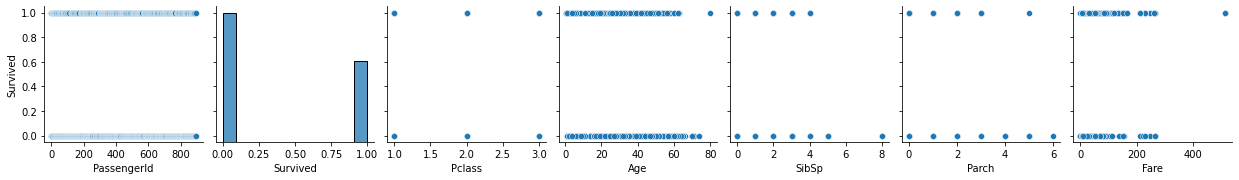

In [ ]:
from seaborn import pairplot
pairplot(training_data, y_vars=['Survived'])

In [ ]:
training_data['Ticket'] = [ string_to_ordinal(x) for x in training_data['Ticket'] ]

In [ ]:
# use a 70/30 split for training/testing for bootstrapping
# and k-folds cross-validation
main_effects = ['Age', 'Fare','Ticket','Pclass','SibSp']
k_folds = [ 
  shuffle(training_data, balance_classes=True, frac=0.7) 
  for i in range(K) ]
# bootstrap our logistic regression for estimating a confidence
# interval (standard error) and mean effect sizes from standardized
# coefficients
logistic_regressions = [ fit_logistic_regression(
    df['training'], variables = main_effects, 
    dummy_variables = ['Sex']) for df in k_folds ]

In [ ]:
# grab the coefficients and standard error values from our bootstrapped 
# logistic regression classifiers
std_effect_sizes(logistic_regressions)

,est,se
Intercept,1.641831,0.002211
Age,-0.543085,0.002026
Fare,0.058906,0.001870
Ticket,0.028484,0.002075
Pclass,-0.265599,0.002670
SibSp,0.098592,0.002210
Sex_female,1.209219,0.001747
Sex_male,-1.209214,0.001747


In [ ]:
lreg_cv_results = pd.DataFrame(cross_validation(
  logistic_regressions, k_folds=k_folds, variables=main_effects, 
  dummy_variables=["Sex"], apply_scale = True))

In [ ]:
lreg_cv_results[2]

0       0.100000
1       0.111111
2       0.189189
3       0.022727
4       0.136364
          ...   
9994    0.135135
9995    0.100000
9996    0.150000
9997    0.121951
9998    0.129032
Name: 2, Length: 9999, dtype: float64

In [ ]:
from seaborn import histplot
print( lreg_cv_results[0].mean(), (3 * lreg_cv_results[0].std())) 
#histplot(lreg_cv_results[0]

0.7742355711156417 0.16471363532499866


(0.647, 0.558)


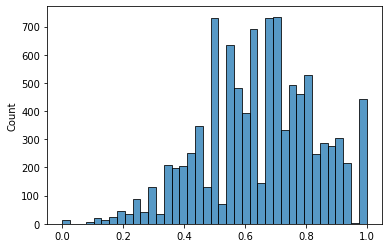

In [ ]:
print( ( np.mean(lreg_omission).round(3), (3 * np.std(lreg_omission)).round(3) ) )
histplot(lreg_omission)

(0.093, 0.183)


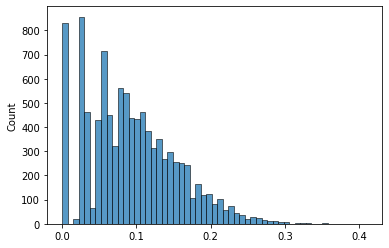

In [ ]:
print( ( np.mean(lreg_comission).round(3), (3 * np.std(lreg_comission)).round(3) ) )
histplot(lreg_comission)

In [ ]:
# Fit an exploratory RF classifier across K replicates to these variables -- they seems to be
# consistently important based on our regression modeling
random_forests = [ fit_random_forests(
  df['training'], variables = ['Age', 'Fare', 'Ticket', 'Pclass', 'SibSp'], dummy_variables=['Sex']) 
  for df in k_folds ]

In [ ]:
rf_overall_accuracy = [] # Overall Accuracy
rf_omission = [] # Type II Error
rf_commission = [] # Type I Error
for i in range(K):
  testing_df = k_folds[i]['testing'].dropna()
  
  # build a design matrix -- random forests doesn't need centering
  design_matrix = encode_design_matrix(
      testing_df[main_effects].join(testing_df['Sex']), 
      variables=main_effects, dummy_variables=['Sex'], normalize=False)
  
  observed = testing_df['Survived']
  predicted = predict(
      m=random_forests[i]["model"], 
      x=design_matrix['x'])
  
  rf_overall_accuracy.append(accuracy(observed, predicted))
  rf_omission.append(omission(observed, predicted))
  rf_commission.append(commission(observed, predicted))

(0.779, 0.164)


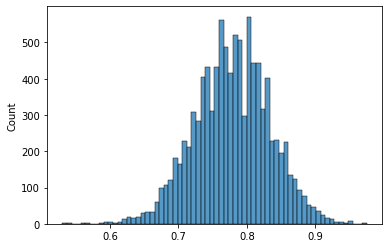

In [ ]:
print( ( np.mean(rf_overall_accuracy).round(3), (3 * np.std(rf_overall_accuracy)).round(3) ) )
histplot(rf_overall_accuracy)

(0.604, 0.486)


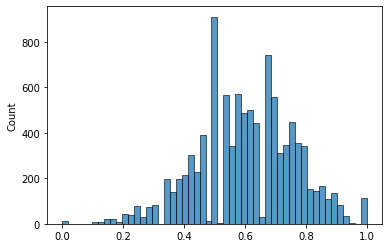

In [ ]:
print( ( np.mean(rf_omission).round(3), (3 * np.std(rf_omission)).round(3) ) )
histplot(rf_omission)

(0.103, 0.173)


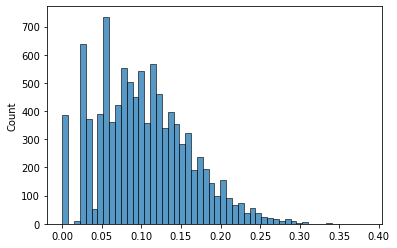

In [ ]:
print( ( np.mean(rf_commission).round(3), (3 * np.std(rf_commission)).round(3) ) )
histplot(rf_commission)